
# Crime Data

I'll be looking at and analyzing data from chicago's crime statistics from 2001 to present year (2023).

### Crime Distribution

The first First thing I would like to do is get an idea of the distribution of crimes across chicago. Luckily, my source at [Data.gov](https://data.gov/) included the IUCR code with each entry. Filtering by that:

In [2]:
from folium.plugins import HeatMap, FastMarkerCluster
from sqlalchemy import create_engine
import matplotlib.ticker as ticker
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import folium
import json

engine = create_engine('sqlite:///sqlite3.db')

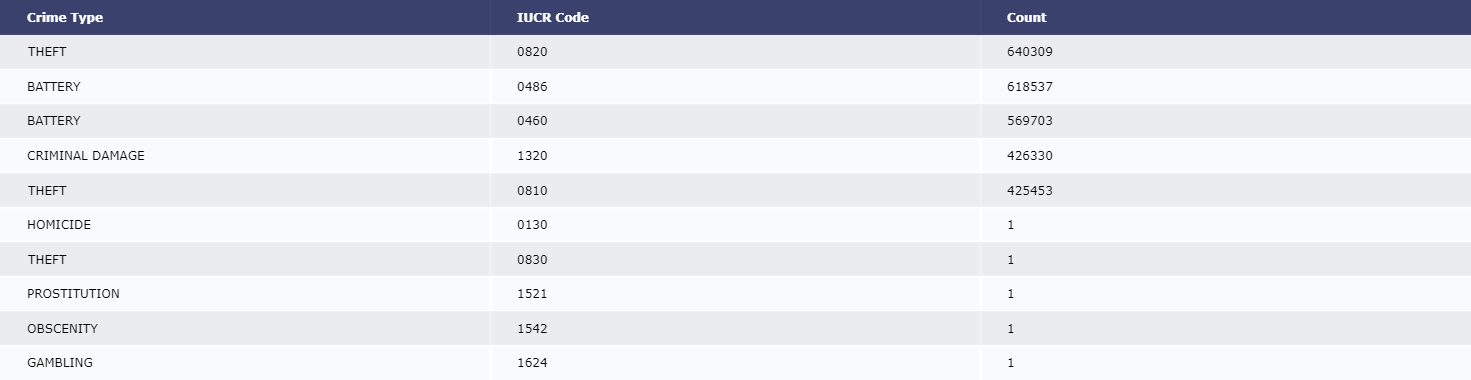

In [3]:

upper_query = '''
select "Primary Type" as "Crime Type", IUCR as "IUCR Code", count(IUCR) as Count
from crime_data
group by IUCR
order by Count desc
limit 5
'''

lower_query = '''
select "Primary Type" as "Crime Type", IUCR as "IUCR Code", count(IUCR) as Count
from crime_data
group by IUCR
order by Count asc
limit 5
'''
upper_df = pd.read_sql(upper_query, engine)
lower_df = pd.read_sql(lower_query, engine)

table_df = pd.concat([upper_df, lower_df], axis=0).reset_index(drop=True)
fig = ff.create_table(table_df)
fig.show()

We have a staggering amount of crimes at the high end of the spectrum, and almost none looking at the low end. Though this should come as no surprise if you are aware of the [pareto principle](https://en.wikipedia.org/wiki/Pareto_principle).

If we were to plot our data into a histogram, we can get a clearer picture of the distribution.

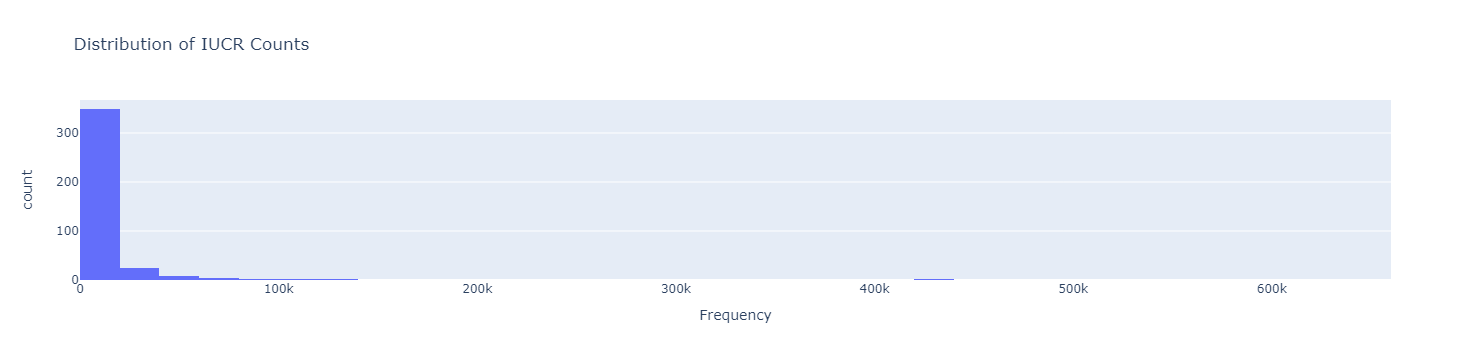

In [4]:
query = '''
select IUCR, count(IUCR) as Count
from crime_data
group by IUCR
order by Count desc
'''
df = pd.read_sql(query, engine)
fig = px.histogram(df, x="Count", title="Distribution of IUCR Counts", nbins=50, labels={"Count": "Frequency"})
fig.show()

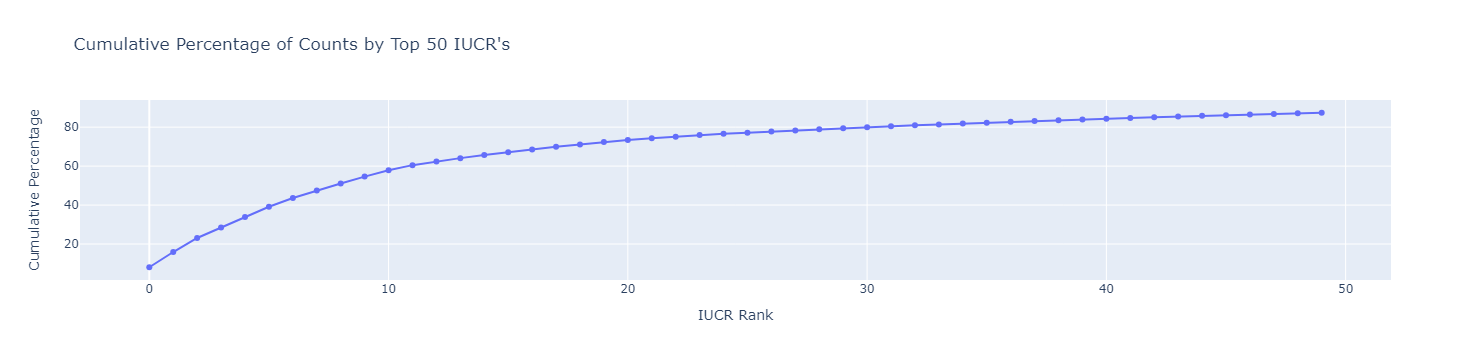

In [5]:
df['Cumulative Percentage'] = df['Count'].cumsum() / df['Count'].sum() * 100

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.head(50).index,
                        y = df.head(50)['Cumulative Percentage'],
                        mode='lines+markers',
                         name="Cumulative Percentage"
                        ))

fig.update_layout(title="Cumulative Percentage of Counts by Top 50 IUCR's",
                  xaxis_title="IUCR Rank",
                  yaxis_title="Cumulative Percentage"
                 )

fig.show()

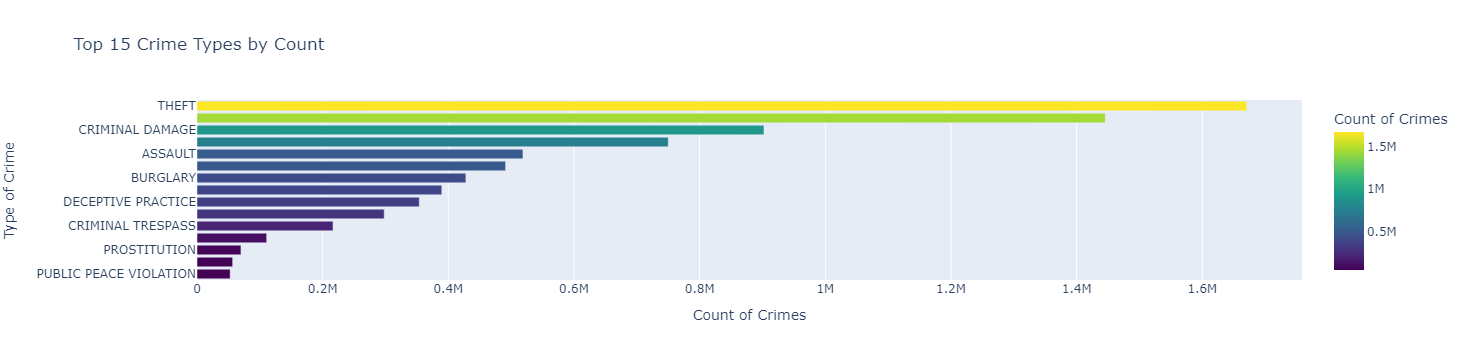

In [6]:
new_query = '''
select `Primary Type`, count(*) as `Crime Count`
from crime_data
group by `Primary Type`
order by `Crime Count` desc;'''

crimes_by_type = pd.read_sql(new_query, engine)
top_15 = crimes_by_type.sort_values(by="Crime Count", ascending=False).head(15)

fig = px.bar(top_15,
            x="Crime Count",
            y="Primary Type",
            orientation='h',
            title="Top 15 Crime Types by Count",
            labels={"Crime Count": "Count of Crimes", "Primary Type": "Type of Crime"},
            color="Crime Count",
            color_continuous_scale='Viridis')

fig.update_yaxes(categoryorder="total ascending")

fig.show()

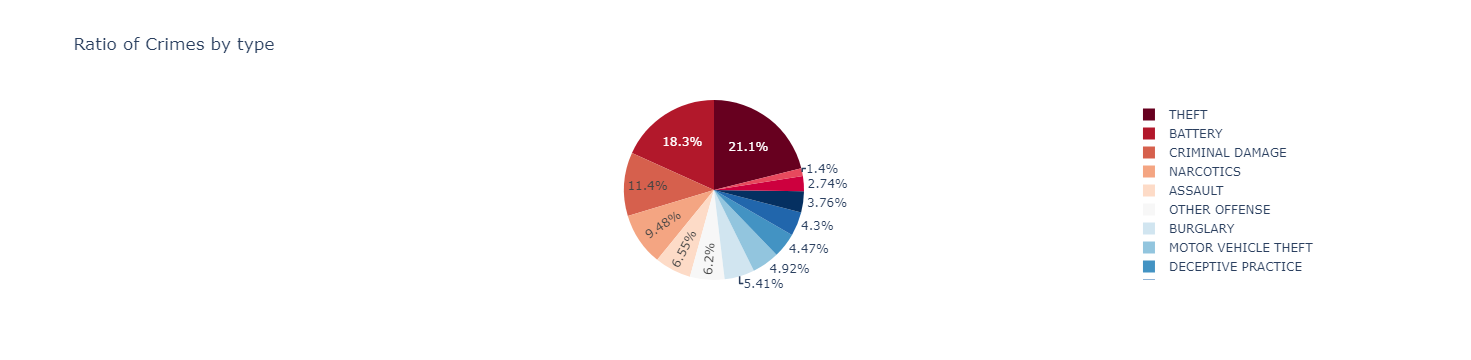

In [7]:
total_crimes = crimes_by_type["Crime Count"].sum()

mask = (crimes_by_type["Crime Count"] / total_crimes) < 0.01

other_row = pd.DataFrame({
    "Primary Type": ["OTHER"],
    "Crime Count": [crimes_by_type.loc[mask, "Crime Count"].sum()]
})

crimes_by_type_cleaned =pd.concat([crimes_by_type[~mask], other_row], ignore_index=True)

fig = px.pie(crimes_by_type_cleaned,
            values="Crime Count",
            names="Primary Type",
            title="Ratio of Crimes by type",
            color_discrete_sequence=px.colors.sequential.RdBu)

fig.show()

### Yearly Crime Statistics

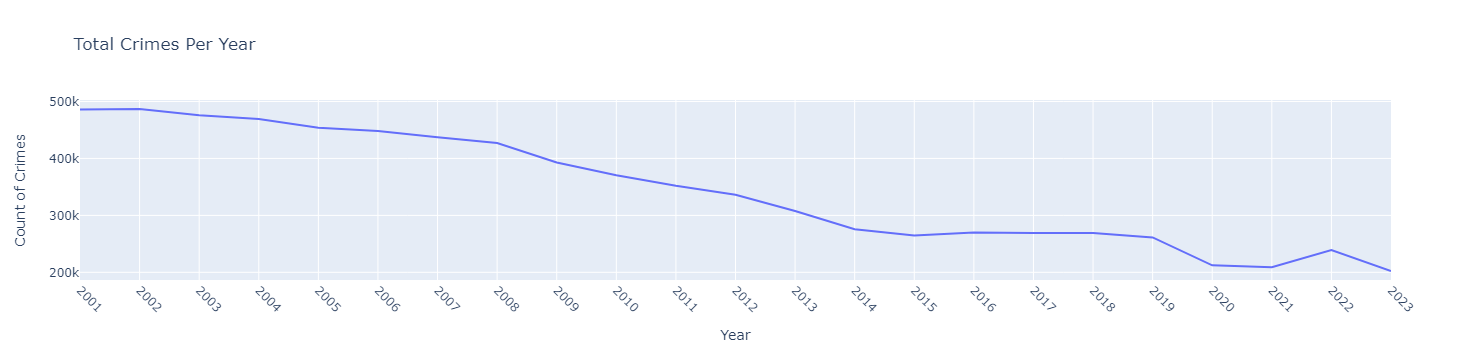

In [8]:
query_total_yearly = '''
select Year, count(*) as "Total Crimes"
from crime_data
group by Year
order by Year asc
'''

df_total_yearly = pd.read_sql(query_total_yearly, engine)

fig = px.line(df_total_yearly, x="Year", y="Total Crimes",title="Total Crimes Per Year",labels={"Total Crimes": "Count of Crimes"})

fig.update_layout(
    xaxis=dict(
        tickvals=df_total_yearly['Year'].unique(),
        tickangle=45
    )
)

fig.show()

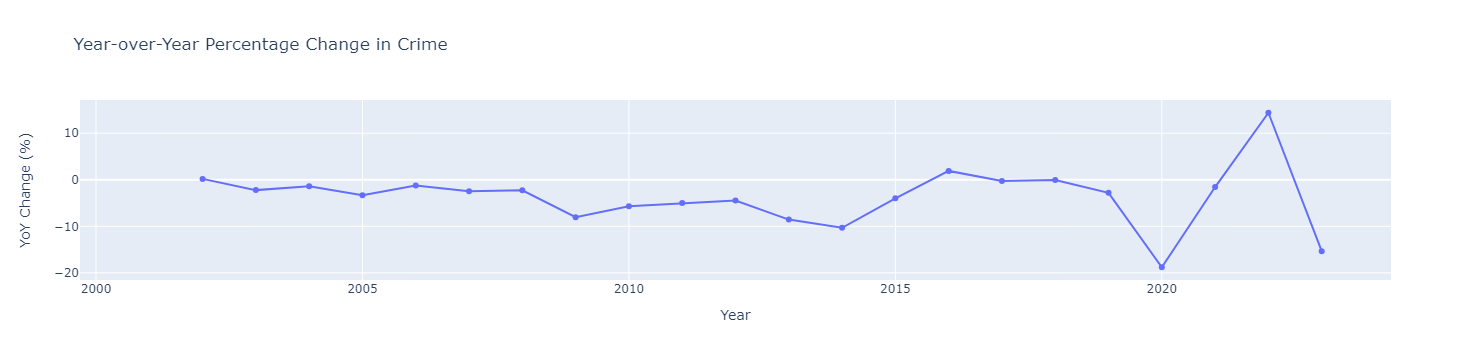

In [9]:
yearly_crimes = pd.read_sql(query_total_yearly, engine)
yearly_crimes["YoY Change (%)"] = yearly_crimes["Total Crimes"].pct_change() * 100

fig = px.line(yearly_crimes,
              x="Year",
              y="YoY Change (%)",
              title='Year-over-Year Percentage Change in Crime',
              markers=True)

fig.update_layout(yaxis_title="YoY Change (%)", xaxis_title="Year")
fig.show()

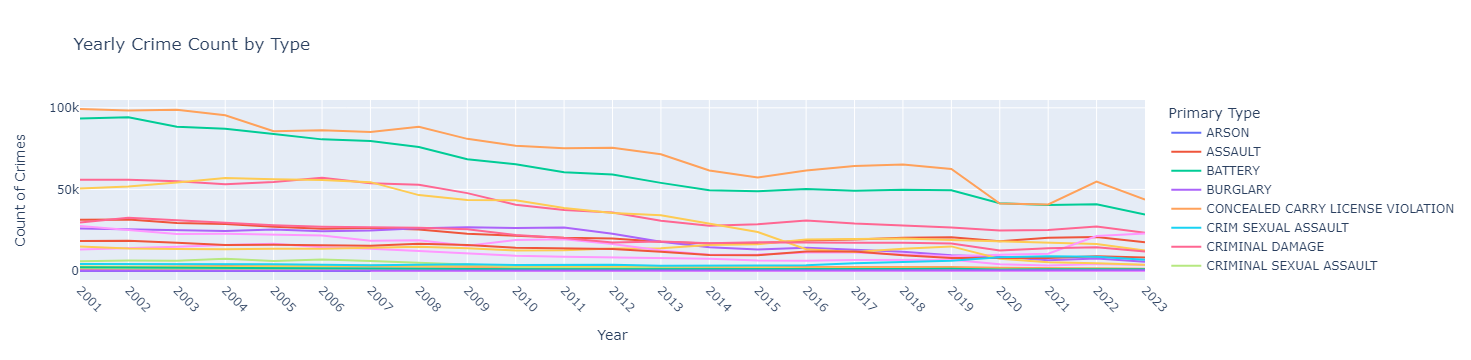

In [10]:

query_yearly = '''
SELECT `Year`, `Primary Type`, COUNT(*) as `Crime Count`
FROM crime_data
GROUP BY `Year`, `Primary Type`
ORDER BY `Year` ASC, `Crime Count` DESC
'''

df_yearly = pd.read_sql(query_yearly, engine)
df_yearly_pivot = df_yearly.pivot(index='Year', columns='Primary Type', values='Crime Count')
df_yearly_long = df_yearly_pivot.reset_index().melt(id_vars='Year', var_name='Primary Type', value_name='Crime Count')

fig = px.line(df_yearly_long, x='Year', y='Crime Count', color='Primary Type', 
              title="Yearly Crime Count by Type",
              labels={'Crime Count': 'Count of Crimes'})

fig.update_layout(
    xaxis=dict(
        tickvals=df_yearly_long['Year'].unique(),
        tickangle=45
    )
)

fig.show()

2008 - 2014 -> Decline in number of crimes is evident. Other city wide events that occured during that time?


2019 - 202 ->, shar pdecrease? caused by the pandem??


2020 - 20 ->1, height of the pandemic, crime platu?

d
2021 - 2 ->22, sharp rise. return to norm

l?
2015 -  ->019, seems to have stayed nantstag? what events may have cauthis.ant?

Will need some follow up on these counts here.

### Crimes by Location

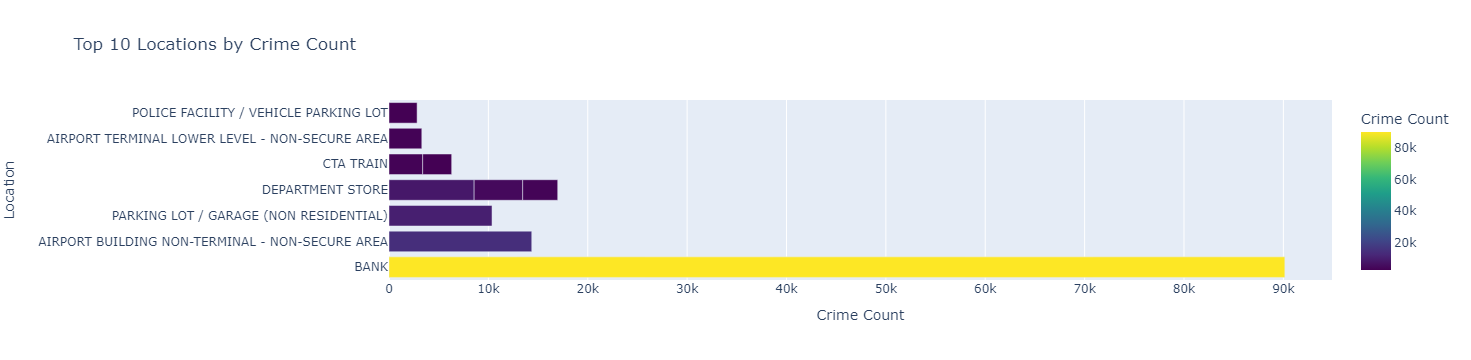

In [11]:
location_query = '''
select "Location Description" as Location, count(*) as "Crime Count"
from crime_data
group by Location
order by "Crime Count" desc
limit 10
'''

locations_by_crime = pd.read_sql(location_query, engine)

fig = px.bar(locations_by_crime,
            x="Crime Count",
            y="Location",
            orientation='h',
            title="Top 10 Locations by Crime Count",
            color="Crime Count",
            color_continuous_scale="Viridis")

fig.show()

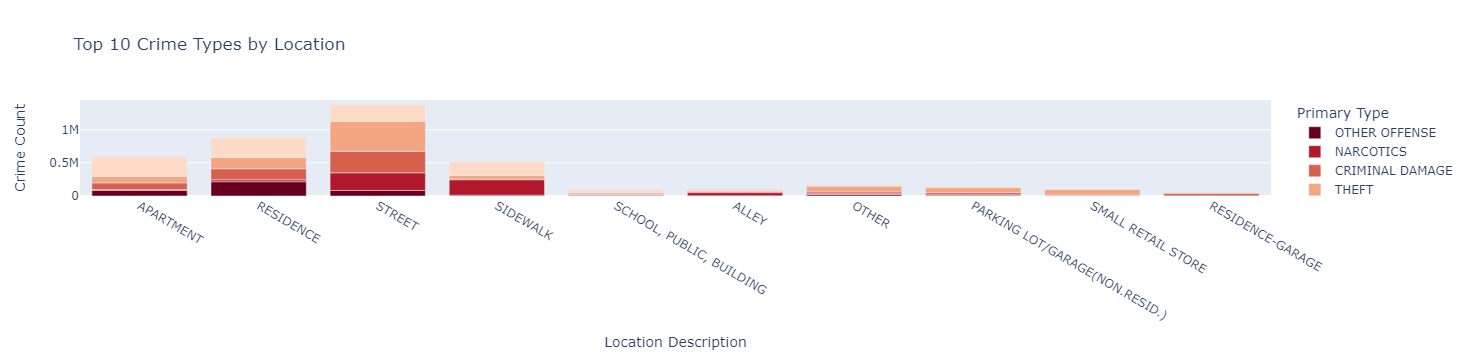

In [12]:
crime_type_by_location_query = '''
SELECT `Location Description`, `Primary Type`, COUNT(*) as `Crime Count`
FROM crime_data
WHERE `Location Description` IN (
    SELECT `Location Description`
    FROM crime_data
    GROUP BY `Location Description`
    ORDER BY COUNT(*) DESC
    LIMIT 10  -- Adjust this number to match the number of top locations from the previous query
)
GROUP BY `Location Description`, `Primary Type`
ORDER BY `Location Description`, `Crime Count` DESC;
'''

crime_type_by_location = pd.read_sql(crime_type_by_location_query, engine)

pivot_df = crime_type_by_location.pivot_table(index='Location Description', columns='Primary Type', values='Crime Count', aggfunc='sum').fillna(0)

top_crime_types = crime_type_by_location.groupby('Primary Type').sum().nlargest(5, 'Crime Count').index.tolist()
pivot_df = pivot_df[top_crime_types]
pivot_df = pivot_df.sort_values(by=top_crime_types[0], ascending=False)
pivot_df = pivot_df[top_crime_types[::-1]]

fig = px.bar(pivot_df, 
             title="Top 10 Crime Types by Location",
             labels={'value': 'Crime Count', 'variable': 'Crime Type', 'index': 'Location'},
             color_discrete_sequence=px.colors.sequential.RdBu)

fig.show()

### Time analysis

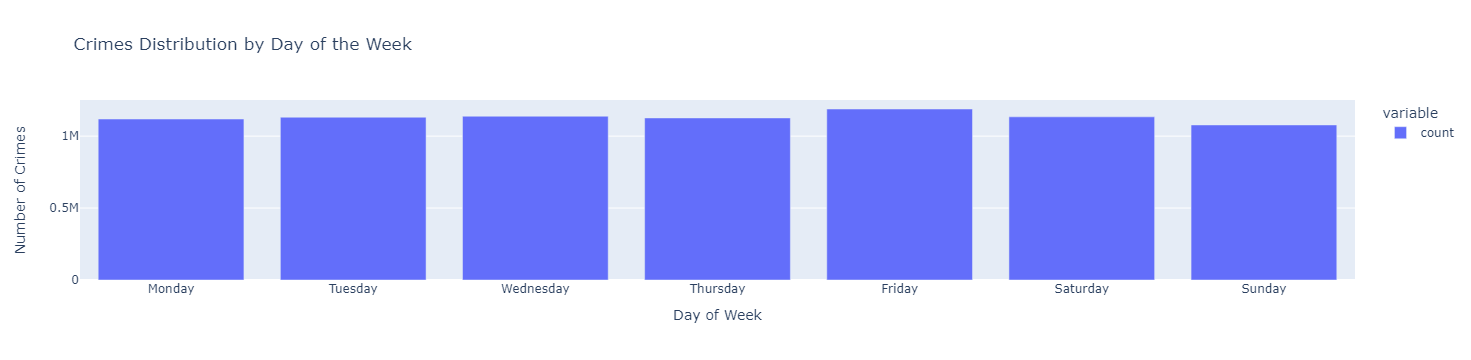

In [13]:
time_query = '''
select Date, "Primary Type" from crime_data
'''

crime_data = pd.read_sql(time_query, engine)

crime_data['Day of Week'] = pd.to_datetime(crime_data['Date']).dt.day_name()

daily_counts = crime_data['Day of Week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

fig = px.bar(daily_counts, 
             title="Crimes Distribution by Day of the Week", 
             labels={'value': 'Number of Crimes', 'index': 'Day of the Week'})
fig.show()

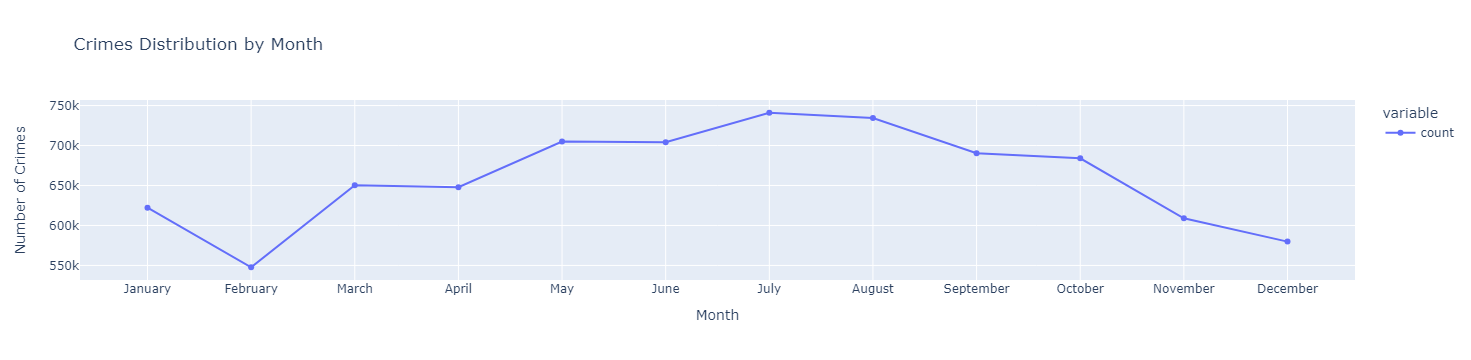

In [18]:
crime_data["Month"] = pd.to_datetime(crime_data["Date"]).dt.month_name()

monthly_counts = crime_data["Month"].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
])

fig = px.line(monthly_counts,
              title="Crimes Distribution by Month",
              labels={"value": "Number of Crimes", "index": "Month"},
              markers=True)

fig.show()

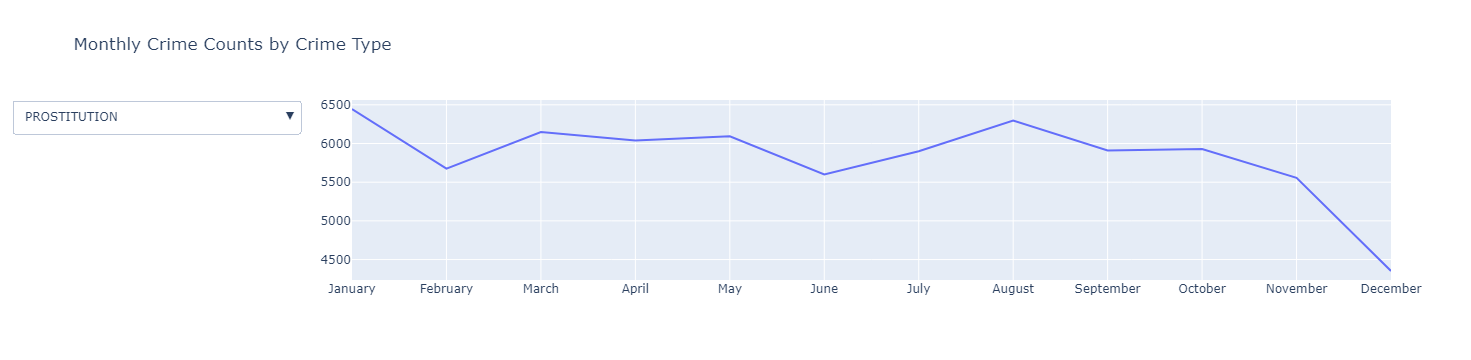

In [14]:
crime_data['Month'] = pd.to_datetime(crime_data['Date']).dt.month_name()
crime_data['Year'] = pd.to_datetime(crime_data['Date']).dt.year

traces = []
crime_types = crime_data["Primary Type"].unique()

for crime_type in crime_types:
    filtered_data = crime_data[crime_data['Primary Type'] == crime_type]
    monthly_counts = filtered_data.groupby('Month').size().reindex([
        'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
    ])
    
    trace = go.Scatter(x=monthly_counts.index, y=monthly_counts.values, mode='lines', name=crime_type)
    traces.append(trace)

layout = go.Layout(
    title="Monthly Crime Counts by Crime Type",
    updatemenus=[{
        "buttons": [
            {"args": [{"visible": [True if crime_type == trace['name'] else False for trace in traces]}], 
             "label": crime_type, 
             "method": "update"} for crime_type in crime_types],
        "direction": "down",
        "showactive": True
    }]
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

In [16]:
location_query = '''
select "Community Area", count("Community Area") as "Community Count"
from crime_data
where "Community Area" is not null
group by "Community Area"
'''

location_df = pd.read_sql(location_query, engine)

m = folium.Map(location=[41.83, -87.68], zoom_start=11, tiles="cartodb positron")

geojson_path = "./Community Areas (current).geojson"

with open(geojson_path, "r") as f:
    chicago_communities = json.load(f)

folium.Choropleth(
    geo_data=geojson_path,
    name="choropleth",
    data=location_df,
    columns=["Community Area", "Community Count"],
    key_on='feature.properties.area_numbe',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Crimes by Community Area"
).add_to(m)

for feature in chicago_communities["features"]:
    community_name = feature["properties"]["community"]
    community_num = feature["properties"]["area_num_1"]
    num_crimes = int(location_df[location_df["Community Area"] == float(community_num)]["Community Count"].iloc[0])
    popup_text = f"{community_name}<br>Total Crimes: {num_crimes}"

    folium.GeoJson(
        feature,
        style_function=lambda feature: {
            'fillColor': "transparent",
            'color': 'transparent',
            'weight': 0.5,
            'dashArray': '5, 5',
            'fillOpacity': 0.6,
        },
        tooltip=popup_text
    ).add_to(m)

folium.LayerControl().add_to(m)

m